# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2</center>



Los conjuntos de datos a utilizar train y test se encuentran disponibles en la competencia de Kaggle y deberán descargarlos desde allí. Allí mismo encontrarán también un archivo de ejemplo de cómo se deben subir las soluciones.
El trabajo consiste en construir diferentes modelos de clasificación, capaces de analizar una porción de texto en lenguaje natural y detectar el sentimiento allí presente, al menos de forma binaria: positivo o negativo.
Para ello habrá que realizar un preprocesamiento del texto para que este pueda ser analizado por los distintos modelos. Se utilizará el modelo de bag of words, o cualquier otro que permita
convertir texto en vectores.


Los modelos que se deben construir son los siguientes:

- Bayes Naïve
- Random Forest
- XGBoost
- Un modelo de red neuronal aplicando Keras y Tensor Flow.
- Un ensamble de al menos 3 modelos elegidos por el grupo.

Para cada uno de estos modelos se debe realizar una búsqueda de hiperparametros que
optimicen su desempeño en el conjunto de test local (porción del archivo training).
Una vez encontrados dichos hiperparametros, se procederá a hacer un submit a Kaggle. Es decir
que habrá al menos 5 submits (uno por cada modelo).

In [ ]:
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


# Inicialización de entorno

## Librerias

In [ ]:
pip install scikeras

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import time
from scipy.stats import uniform, randint


#preprocecsamiento
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import nltk
from nltk.corpus import stopwords

#modelos
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier
)
import xgboost as xgb

#redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

#Cross validation
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)

#Metricas
from sklearn.metrics import(
    confusion_matrix,
    make_scorer,
    recall_score,
    accuracy_score,
    f1_score,
    precision_score
)

#guardado
import pickle
import dill

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Funciones

### Graficas

In [2]:
plt.style.use('ggplot')

In [3]:
def barplot(data, column):

    fig, ax = plt.subplots()
    data[column].value_counts().plot(ax=ax, kind='bar')
    plt.locator_params('x', nbins=2)

    plt.ylabel('Frecuencia')
    plt.xlabel(column)
    plt.xticks(rotation=360)
    plt.title('Distribución de ' +  column)

    plt.show()

### Metricas

In [4]:
def metricas_modelo(test, pred, model_name='el modelo'):
    #Calculo las métricas en el conjunto de evaluación
    accuracy = accuracy_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)
    precision = precision_score(test, pred)

    metrics=[[str(round(accuracy,5)),
              str(round(recall,5)),
              str(round(precision,5)),
              str(round(f1,5))
            ]]
    labels=['Accuracy',
            'Recall',
            'Precision',
            'F1'
            ]

    matriz = confusion_matrix(test, pred)
    
    title="Matriz de confusión y métricas para " + model_name
    
    plt.title(title)
    t = plt.table(cellText=metrics,
                  colLabels=labels,
                  bbox=(1.5, .1, 0.75, 0.75))
    t.auto_set_font_size(False)
    t.set_fontsize(11)


    #Grafico la matriz de confusión
    sns.heatmap(matriz.T ,cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [5]:
def timer_flag(t):
    time_format = time.strftime("%M:%S", time.gmtime(round(t)))
    print("Tiempo transcurrido: ", time_format, " minutos")
    print("_______________________________")

In [6]:
def metricas_cv(model, t=None):
  print("Resultados del Cross Validation")
  print("_______________________________")
  timer_flag(t)
  #Mejores hiperparametros
  print("Mejores hiperparametros: ", model.best_params_)
  #Mejor métrica
  print("Mejor métrica F1: ",model.best_score_)

### Entrenamiento

In [7]:
def Randomized_Cross_Validation(x_data, y_data, classifier, parameters, folds=5, iterations=10):
    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(sk.metrics.f1_score)

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    model_rand = RandomizedSearchCV(estimator=classifier,
                                    param_distributions = parameters,
                                    scoring=scorer_fn,
                                    cv=kfoldcv,
                                    n_iter=iterations,
                                    n_jobs=-1)

    #Se entrena el modelo tomando el tiempo que tarda
    t_inicio = time.perf_counter()
    model_rand.fit(x_data, y_data)
    t_final = time.perf_counter()

    #Se muestran las métricas más relevantes
    metricas_cv(model_rand, t_final-t_inicio)

    return model_rand.best_estimator_

In [8]:
def Grid_Cross_Validation(x_data, y_data, classifier, parameters, folds=5):

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(sk.metrics.f1_score)

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    model_grid = GridSearchCV(estimator=classifier, param_grid=parameters, scoring=scorer_fn, cv=kfoldcv, n_jobs=-1)

    #Se entrena el modelo tomando el tiempo que tarda
    t_inicio = time.perf_counter()
    model_grid.fit(x_data, y_data)
    t_final = time.perf_counter()

    metricas_cv(model_grid, t_final-t_inicio)

    return model_grid.best_estimator_

In [9]:
def make_prediction(model, model_name, x_data, y_data):
    #Predicción
    y_pred = model.predict(x_data)

    metricas_modelo(y_data, y_pred, model_name)

## Dataset

In [10]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/TP2/Datasets/train.csv'
df_train = pd.read_csv(db_train_url)

In [11]:
df_train.shape

(50000, 3)

In [12]:
df_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


# Preprocessing

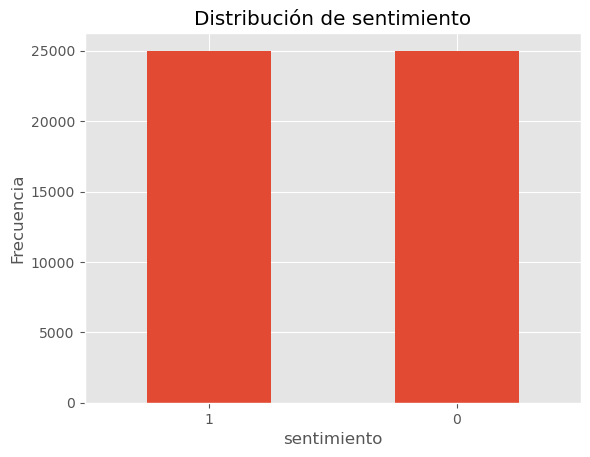

In [13]:
df_train['sentimiento'] = df_train['sentimiento'].replace(to_replace=['positivo', 'negativo'], value=[1, 0])
barplot(df_train, 'sentimiento')

In [14]:
id = 'ID'

x_train, x_test, y_train, y_test = train_test_split(df_train.review_es,
                                                    df_train.sentimiento,
                                                    test_size=0.30,  #proporcion 70/30
                                                    random_state=2, #semilla
                                                    stratify=df_train.sentimiento.values)

## Stopwords

In [15]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None)
bag = vectorizer.fit_transform(x_test)
len(vectorizer.vocabulary_)

98066

In [ ]:
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

In [17]:
preprocess = TfidfVectorizer(analyzer = "word", tokenizer = None, stop_words=spanish_stopwords)
vectorizer = preprocess.fit_transform(x_test)
len(preprocess.vocabulary_)

97829

## Vectorizadores Bag of Words

In [18]:
preprocess_count = CountVectorizer(analyzer = "word", 
                                   tokenizer = None, 
                                   stop_words=spanish_stopwords)

In [19]:
preprocess_normalized = TfidfVectorizer(analyzer = "word", 
                                        tokenizer = None, 
                                        stop_words=spanish_stopwords)

In [20]:
preprocess_reduced = TfidfVectorizer(analyzer = "word", 
                                     tokenizer = None, 
                                     stop_words=spanish_stopwords, 
                                     max_features = 50000)

# Entrenamiento

## Naive Bayes

### Modelo base (Multinomial)

#### Bag of words: Count Vectorizer

Tiempo transcurrido:  00:03  minutos
_______________________________


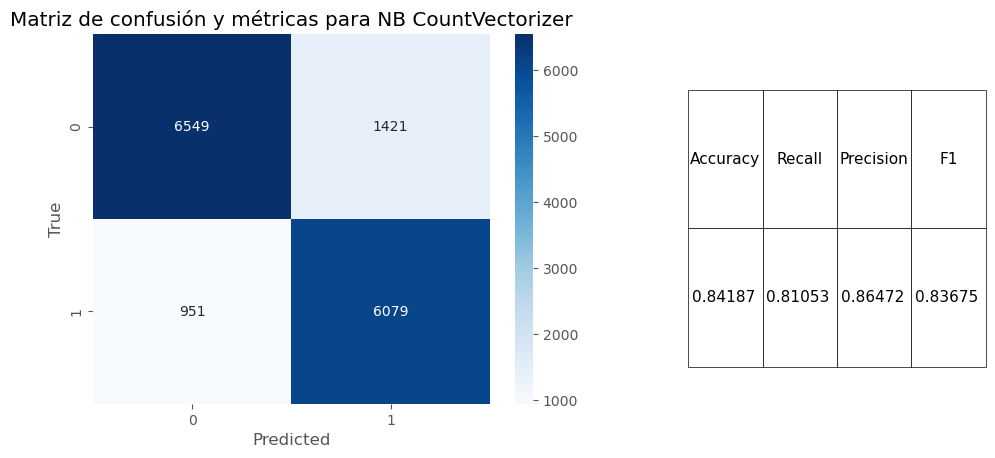

In [68]:
steps = [
    ('preprocess', preprocess_count),
    ('clf', MultinomialNB())
]

NB_Count = Pipeline(steps)

t_inicio = time.perf_counter()
NB_Count.fit(x_train, y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

make_prediction(NB_Count, "NB CountVectorizer", x_test, y_test)

In [69]:
model_file_name = "NB_base_CountVectorizer" + ".pkl"

pickle.dump(NB_Count, open(model_file_name, "wb"))

#### Bag of words: Tfid Vectorizer (Normalizado)

Tiempo transcurrido:  00:03  minutos
_______________________________


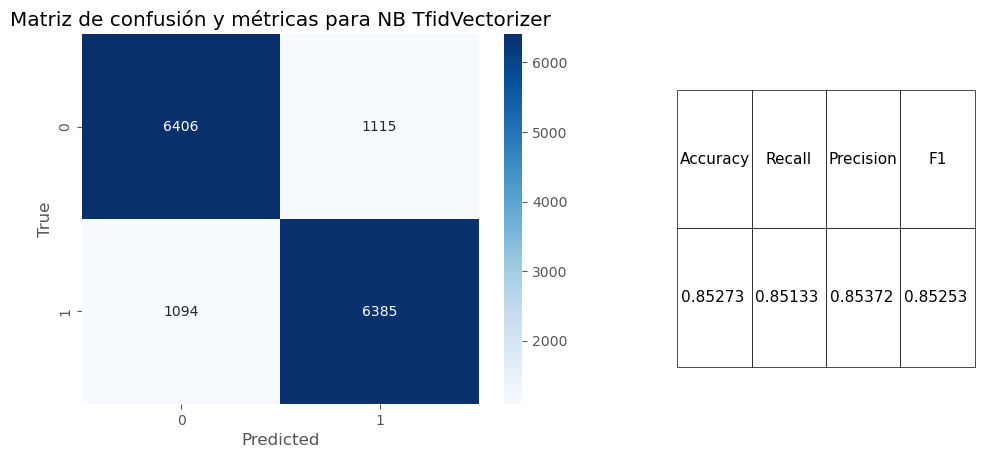

In [70]:
steps = [
    ('preprocess', preprocess_normalized),
    ('clf', MultinomialNB())
]

NB_Tfid = Pipeline(steps)

t_inicio = time.perf_counter()
NB_Tfid.fit(x_train, y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

make_prediction(NB_Tfid, "NB TfidVectorizer", x_test, y_test)

In [71]:
model_file_name = "NB_base_TfidVectorizer" + ".pkl"

pickle.dump(NB_Tfid, open(model_file_name, "wb"))

### Cross Validation (Grid Search)

In [72]:
estimator = MultinomialNB(force_alpha=True)

steps = [
    ('preprocess', preprocess_normalized),
    ('clf', estimator)
]

nb_pipe = Pipeline(steps)

In [73]:
estimator.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [74]:
#Grilla de Parámetros
params = {
    'clf__alpha': np.arange(0,1.001,0.01), # poda
}

np.seterr(divide='ignore', invalid='ignore')

best_NB_Grid = Grid_Cross_Validation(x_train, y_train, classifier=nb_pipe, parameters=params)

Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  04:36  minutos
_______________________________
Mejores hiperparametros:  {'clf__alpha': 0.55}
Mejor métrica F1:  0.8524227068111454


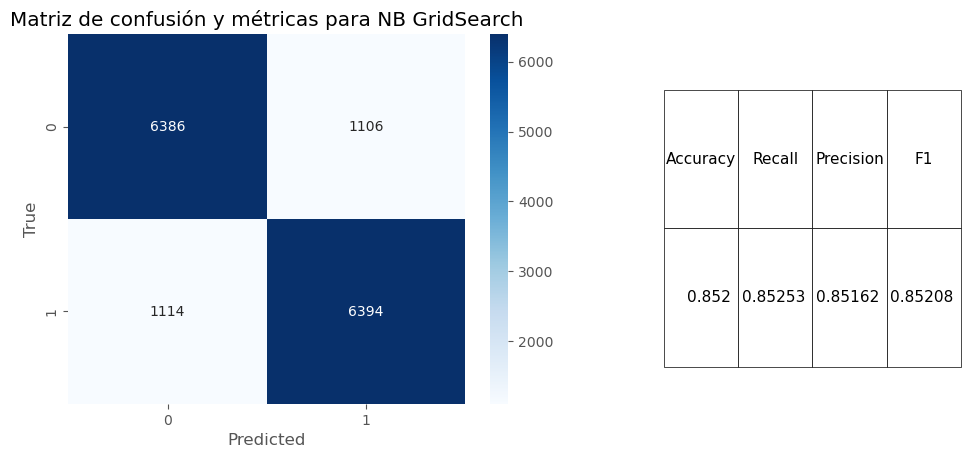

In [75]:
make_prediction(best_NB_Grid, "NB GridSearch", x_test, y_test)

In [76]:
model_file_name = "NB_GridSearch" + ".pkl"

pickle.dump(best_NB_Grid, open(model_file_name, "wb"))

## XGBoost

### Modelo base

Tiempo transcurrido:  00:08  minutos
_______________________________


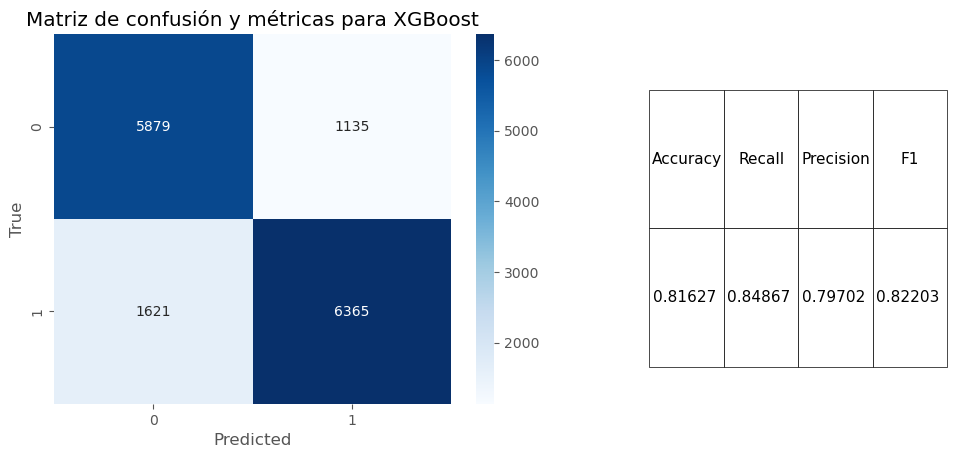

In [77]:
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=50)

steps = [
    ('preprocess', preprocess_reduced),
    ('clf', xgb_model)
]

xgboost_pipe = Pipeline(steps)

#Se entrena modelo con el set completo

t_inicio = time.perf_counter()
xgboost_pipe.fit(x_train, y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

make_prediction(xgboost_pipe, "XGBoost", x_test, y_test)

In [78]:
model_file_name = "XGBoost_base" + ".pkl"

pickle.dump(xgboost_pipe, open(model_file_name, "wb"))

### Cross Validation (Randomized Search)

In [79]:
xgb_class = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

steps = [
    ('preprocess', preprocess_normalized),
    ('clf', xgb_class)
]

xgb_cv_pipe = Pipeline(steps)

xgb_class.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [80]:
param_dist = {
    'preprocess__max_features': [5000, 10000, 20000, 50000, 75000],
    'clf__max_depth': randint(3, 10),  # Rango de profundidad máxima del árbol
    'clf__learning_rate': uniform(0.01, 0.3),  # Rango de tasas de aprendizaje
    'clf__subsample': uniform(0.5, 0.5),  # Rango de valores de subsample
    'clf__colsample_bytree': uniform(0.5, 0.5),  # Rango de valores de colsample_bytree
    'clf__gamma': uniform(0, 5),  # Rango de valores de gamma
    'clf__n_estimators': [100, 500, 1000],  # Valores discretos para el número de estimadores
}

best_xgb = Randomized_Cross_Validation(x_train, y_train, classifier=xgb_cv_pipe, parameters=param_dist)

Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  22:37  minutos
_______________________________
Mejores hiperparametros:  {'clf__colsample_bytree': 0.7906733956233418, 'clf__gamma': 4.861702447101156, 'clf__learning_rate': 0.24257500795548073, 'clf__max_depth': 5, 'clf__n_estimators': 500, 'clf__subsample': 0.8796686986457685, 'preprocess__max_features': 75000}
Mejor métrica F1:  0.8605667113409752


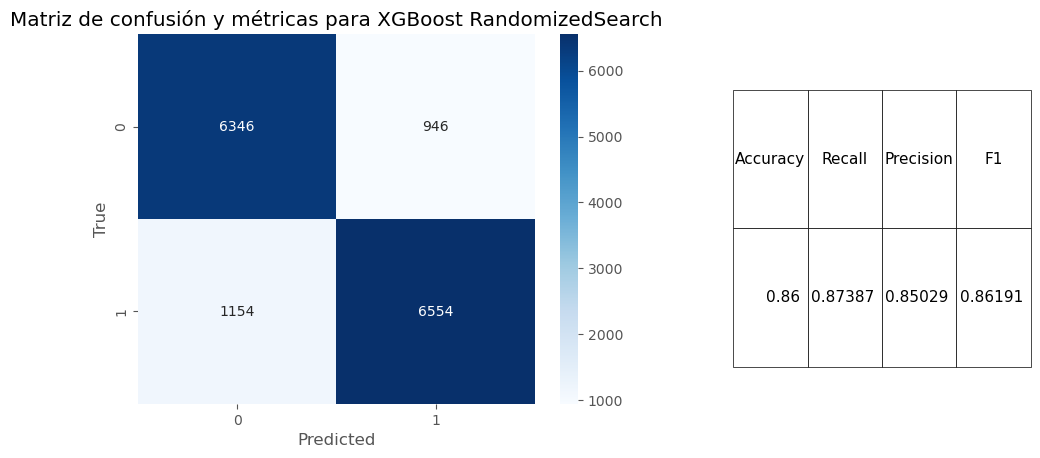

In [81]:
make_prediction(best_xgb, "XGBoost RandomizedSearch", x_test, y_test)

In [82]:
model_file_name = "XGBoost_RandomizedSearch" + ".pkl"

pickle.dump(best_xgb, open(model_file_name, "wb"))

## Random Forest

### Modelo base

Tiempo transcurrido:  00:04  minutos
_______________________________


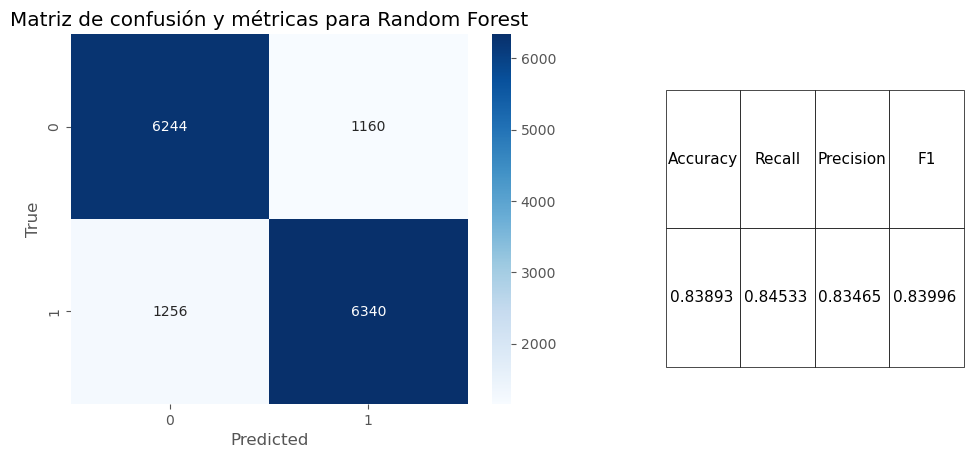

In [83]:
#Creamos un clasificador con hiperparámetros arbitrarios
rfc = RandomForestClassifier(oob_score=True,
                             random_state=2,
                             n_jobs=-1,
                             criterion="entropy",
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50
                             )

steps = [
    ('preprocess', preprocess_reduced),
    ('clf', rfc)
]

rfc_pipe = Pipeline(steps)

#Entrenamos el modelo

t_inicio = time.perf_counter()
rf_model = rfc_pipe.fit(X = x_train, y = y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

make_prediction(rf_model, "Random Forest", x_test, y_test)

In [84]:
model_file_name = "RF_base" + ".pkl"

pickle.dump(rf_model, open(model_file_name, "wb"))

### Cross Validation (Randomized Search)

In [85]:
rf_cv = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)

In [86]:
rf_cv.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [87]:
steps = [
    ('preprocess', preprocess_normalized),
    ('clf', rf_cv)
]

rfc_cv_pipe = Pipeline(steps)

param_grid = {
    'preprocess__max_features': [5000, 10000, 20000, 50000, 75000],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__max_depth': [None, 5, 10, 20, 15],
    'clf__min_samples_split': np.arange(1,10,1),
    'clf__min_samples_leaf': np.arange(1,10,1),
}

#Probamos entrenando sólo con 1 métrica
best_rf = Randomized_Cross_Validation(x_train, y_train, classifier=rfc_cv_pipe, parameters=param_grid)

Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  00:50  minutos
_______________________________
Mejores hiperparametros:  {'preprocess__max_features': 10000, 'clf__n_estimators': 200, 'clf__min_samples_split': 3, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': None}
Mejor métrica F1:  0.8500600709963679


Predecimos utilizando el mejor modelo que obtuvimos en entrenamiento

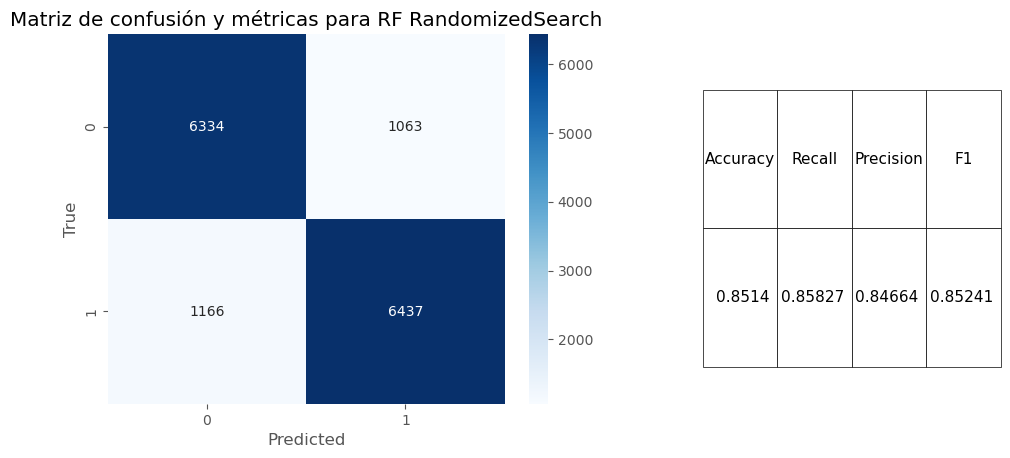

In [88]:
#Predicción
make_prediction(best_rf, "RF RandomizedSearch", x_test, y_test)

In [89]:
model_file_name = "RF_RandomizedSearch" + ".pkl"

pickle.dump(best_rf, open(model_file_name, "wb"))

## Ensamble Voting

### Modelo base

In [21]:
nb_clf = MultinomialNB()
log_clf = LogisticRegression()
rfc_clf = RandomForestClassifier()

e = [('lr', log_clf), ('nb', nb_clf), ('rfc', rfc_clf)]

#Creo ensemble de Votación
voting_clss = VotingClassifier(estimators = e, voting = 'hard')

Tiempo transcurrido:  00:54  minutos
_______________________________


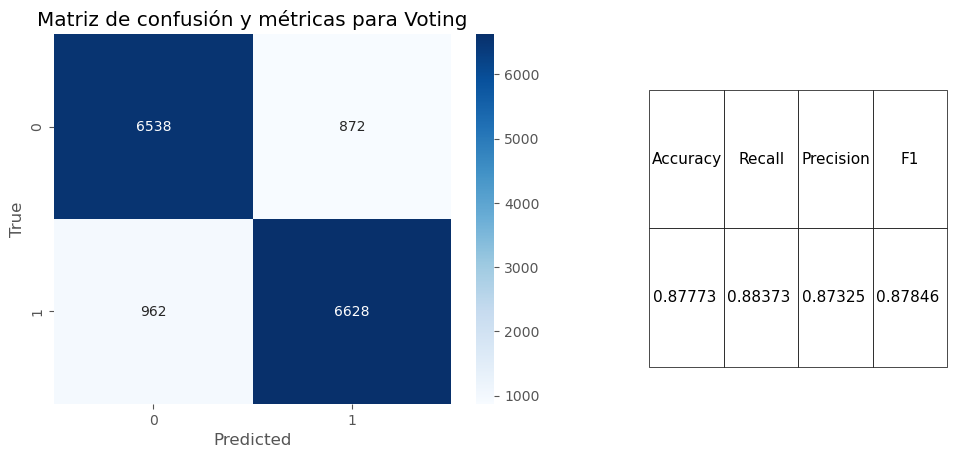

In [22]:
steps = [
    ('preprocess', preprocess_reduced),
    ('clf', voting_clss)
]

vote_pipeline = Pipeline(steps)
#Entreno el ensemble

t_inicio = time.perf_counter()
vote_pipeline.fit(x_train, y_train)
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

#Evaluo en conjunto de test
make_prediction(vote_pipeline, "Voting", x_test, y_test)

In [23]:
model_file_name = "Voting" + ".pkl"

pickle.dump(vote_pipeline, open(model_file_name, "wb"))

### Cross Validation (Randomized Search)

In [32]:
voting_clss.get_params()

{'estimators': [('lr', LogisticRegression()),
  ('nb', MultinomialNB()),
  ('rfc', RandomForestClassifier())],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': None,
 'lr': LogisticRegression(),
 'nb': MultinomialNB(),
 'rfc': RandomForestClassifier(),
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn',
 'rfc__bootstrap': True,
 'rfc__ccp_alpha': 0.0,
 'rfc__class_weight': None,
 'rfc__criterion': 'gini',
 'rfc__max_depth': None,
 'rfc__max_features': 'sqrt',
 'rfc__max_leaf_nodes': None,
 'rfc__max_samples': None,
 'rfc__min_impurity_decrease': 0.0,
 

In [34]:
steps = [
    ('preprocess', preprocess_normalized),
    ('clf', voting_clss)
]

vote_cv_pipeline = Pipeline(steps)

vot_parameters = {
    'preprocess__max_features': [5000, 10000, 20000, 50000, 75000],
    'clf__lr__C':  np.arange(1,10,0.1),
    'clf__lr__penalty':  ['l2', 'l1', 'elasticnet'],
    'clf__lr__max_iter': np.arange(100,1000,100),
    'clf__nb__force_alpha': [ True ],
    'clf__nb__alpha': np.arange(0,1,0.01),
    'clf__rfc__max_features': ['sqrt', 'log2'],
    'clf__rfc__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__rfc__n_estimators': [10, 20, 50, 100, 150, 200],
    'clf__rfc__max_depth': [None, 10, 20, 15],
    'clf__rfc__min_samples_split': np.arange(2,10,1),
    'clf__rfc__min_samples_leaf': np.arange(1,10,1),
}

best_vot = Randomized_Cross_Validation(x_train, y_train, classifier=vote_cv_pipeline, parameters=vot_parameters)


Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  01:06  minutos
_______________________________
Mejores hiperparametros:  {'preprocess__max_features': 20000, 'clf__rfc__n_estimators': 150, 'clf__rfc__min_samples_split': 3, 'clf__rfc__min_samples_leaf': 7, 'clf__rfc__max_features': 'sqrt', 'clf__rfc__max_depth': 20, 'clf__rfc__criterion': 'entropy', 'clf__nb__force_alpha': True, 'clf__nb__alpha': 0.26, 'clf__lr__penalty': 'l2', 'clf__lr__max_iter': 400, 'clf__lr__C': 4.900000000000004}
Mejor métrica F1:  0.8770546706213335


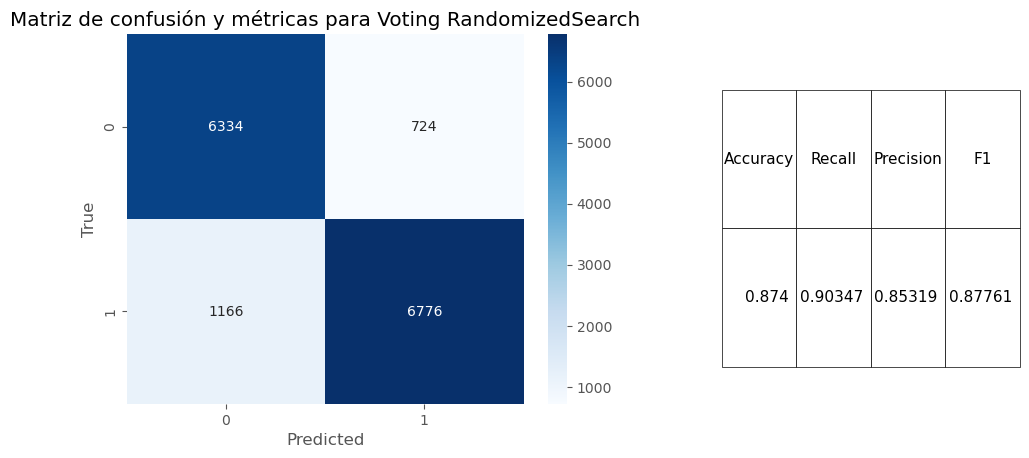

In [35]:
#Predicción
make_prediction(best_vot, "Voting RandomizedSearch", x_test, y_test)

In [36]:
model_file_name = "Voting_RandomizedSearch" + ".pkl"

pickle.dump(best_vot, open(model_file_name, "wb"))

## Red Neuronal

### Densa con Dropout 

In [37]:
d_in = 10000
preprocess_rn = TfidfVectorizer(analyzer = "word", 
                                tokenizer = None, 
                                stop_words=spanish_stopwords,
                                max_features = d_in)

In [38]:
def get_arq():
  model = keras.Sequential([
      # Capa de Entrada
      keras.layers.Dense(50, activation="relu", input_shape=(d_in,)),
      # Capas Ocultas
      keras.layers.Dropout(0.3),
      keras.layers.Dense(50, activation="relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(50, activation="relu"),
      # Capa de salida
      keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(
      optimizer="adam",
      loss="binary_crossentropy",
      metrics=["accuracy"]
  )

  return model

get_arq().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500050    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 505,201
Trainable params: 505,201
Non-trai

2023-06-28 23:05:42.223931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 23:05:42.224301: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [39]:
# Defino Early Stopping
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [40]:
# Creación del pipeline
pipeline_rn = Pipeline([
    ('vectorizer', preprocess_rn),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('model', KerasClassifier(build_fn=get_arq, epochs=30, batch_size=32, verbose=0))
])

# Ajuste del pipeline con Early Stopping
t_inicio = time.perf_counter()
rn_model = pipeline_rn.fit(x_train, y_train, model__callbacks=[early_stopping])
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

Tiempo transcurrido:  00:52  minutos
_______________________________


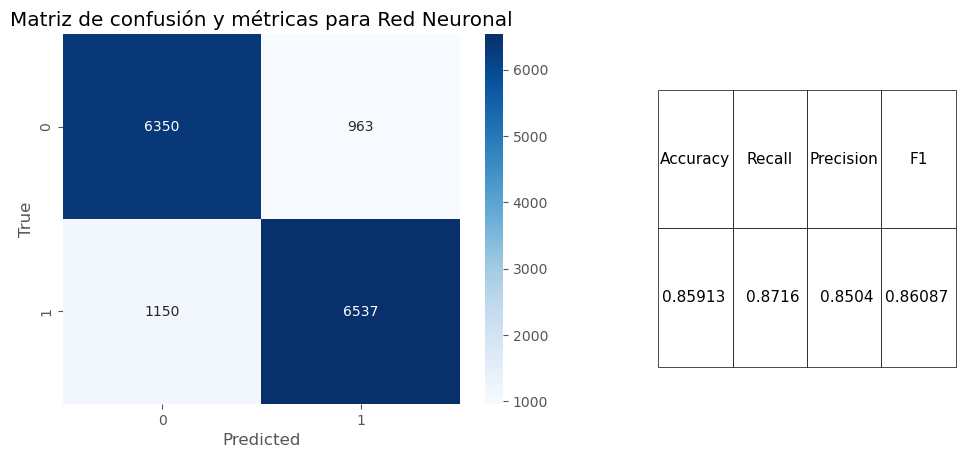

In [41]:
make_prediction(rn_model, "Red Neuronal", x_test, y_test)

In [ ]:
model_file_name = "RN_Densa_Dropout" + ".pkl"

dill.dump(rn_model, open(model_file_name, "wb"))

### Densa con Dropout + CrossValidation

In [43]:
d_in_reduced = 5000
preprocess_rn_reduced = TfidfVectorizer(analyzer = "word", 
                                tokenizer = None, 
                                stop_words=spanish_stopwords,
                                max_features = d_in_reduced)

In [44]:
def get_arq_reduced():
  model = keras.Sequential([
      # Capa de Entrada
      keras.layers.Dense(50, activation="relu", input_shape=(d_in_reduced,)),
      # Capas Ocultas
      keras.layers.Dropout(0.3),
      keras.layers.Dense(50, activation="relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(50, activation="relu"),
      # Capa de salida
      keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(
      optimizer="adam",
      loss="binary_crossentropy",
      metrics=["accuracy"]
  )

  return model

get_arq_reduced().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                250050    
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 255,201
Trainable params: 255,201
Non-tr

In [45]:
pipeline_rn_reduced = Pipeline([
    ('vectorizer', preprocess_rn_reduced),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('model', KerasClassifier(build_fn=get_arq_reduced, epochs=30, batch_size=32, verbose=0))
])

In [46]:
# Defino los parametros
param_grid = {
    'model__epochs': [10, 20, 30],
    'model__batch_size': [16, 32, 64]
}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(pipeline_rn_reduced, param_grid, scoring='accuracy', cv=kfoldcv)

# Ajuste del pipeline con Early Stopping
t_inicio = time.perf_counter()
random_search.fit(x_train, y_train, model__callbacks=[early_stopping])
t_final = time.perf_counter()

timer_flag(t_final-t_inicio)

# Obtengo los mejores parámetros y la mejor puntuación
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Mejores parámetros:", best_params)
print("Mejor puntuación:", best_score)

rn_cv_model = random_search.best_estimator_

Tiempo transcurrido:  17:03  minutos
_______________________________
Mejores parámetros: {'model__epochs': 20, 'model__batch_size': 64}
Mejor puntuación: 0.8534857142857144


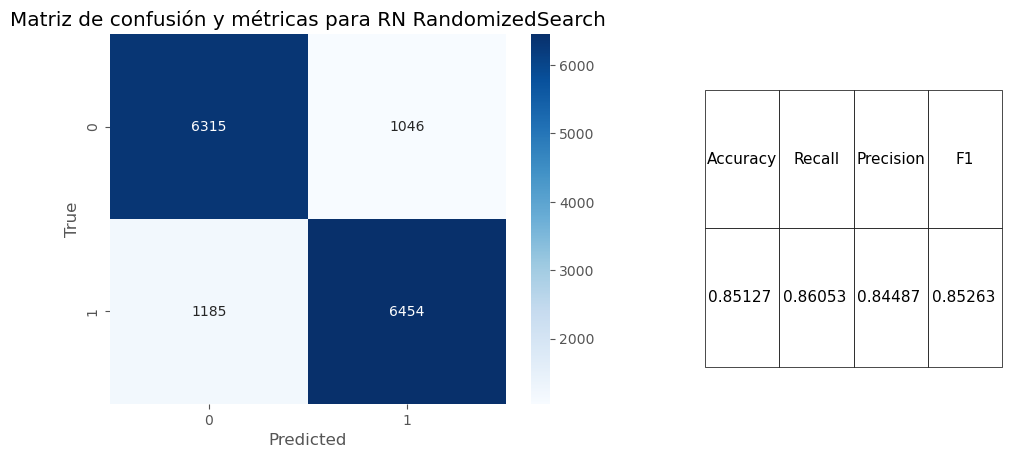

In [47]:
make_prediction(rn_cv_model, "RN RandomizedSearch", x_test, y_test)

In [ ]:
model_file_name = "RN_RandomizedSearch" + ".pkl"

dill.dump(rn_cv_model, open(model_file_name, "wb"))

# Submission

In [ ]:
'''

db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/TP2/Datasets/test.csv'
df_test_submission = pd.read_csv(db_test_url)

model_submission = {"name": "name", "model": model}

y_pred = pd.DataFrame(model_submission["model"].predict(df_test_submission['review_es']))
df_submission = pd.DataFrame({"id": df_test_submission["ID"], "sentimiento": y_pred[0].replace(to_replace=[1, 0], value=['positivo', 'negativo'])})

file_name = model_submission["name"] + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False)

'''
